# Anomaly Detection

## 평가 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항 상세기준
1. 적절한 기본통계분석을 통해 이상치를 분류하였다. : 시계열 Residual에 대한 분석을 통해 신뢰구간 밖의 데이터를 찾고 이상치 종류와 처리방안을 타당하게 제시하였다.
2. Unsupervised Clustering을 통해 이상치를 분류하였다. :  k-mean와 DBSCAN을 통해 이상치 데이터를 찾고 이에 대한 해석과 처리방안을 타당하게 제시하였다.
3. LSTM 오토인코더를 통해 이상치를 분류하였다. : LSTM 오토인코더 학습을 성공적으로 진행한 후, 이상치 데이터를 분류해 보고 이전 결과와 비교하여 보았다.

# 미니 프로젝트 : 다른 시계열 데이터에서 이상치를 찾아보자

# Step 1. 데이터 구하기

이번에는 미국 나스닥 데이터로 진행해 봅니다

In [63]:
import requests
import os

csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/nasdaq.csv'

csv_file


'/home/aiffel0042/aiffel/anomaly_detection/nasdaq/nasdaq.csv'

In [61]:
csv_file

'/home/aiffel0042/aiffel/anomaly_detection/nasdaq/nasdaq.csv'

우선은 야후에서 받아온 데이터를 'nasdaq.csv'로 저장했어요.
Pandas 라이브러리에서 제공하는 DataFrame 타입으로 데이터를 불러와서 값을 확인합니다.

In [64]:
# 저장한 csv를 읽어옵니다.
import pandas as pd
df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0


- 다변량 시계열 데이터의 형태
- 'Date' data type이 string이므로 Datetime 으로 캐스팅하고 결측치 유무를 확인
- 주식 데이터 Open, High, Low, Close, Adj Close, Volume: 시가, 고가, 저가, 종가, 보정종가, 거래량

In [65]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1073
High         1073
Low          1073
Close        1073
Adj Close    1073
Volume       1073
dtype: int64

결측치가 있는 날짜가 1073개! Pandas의 dropna 함수를 사용해서 Nan 값의 결측치를 삭제합니다. 

In [66]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6171
삭제 후 데이터 길이(일자수): 5098


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

정리된 주식데이터를 그래프로 그려 확인해봅니다.

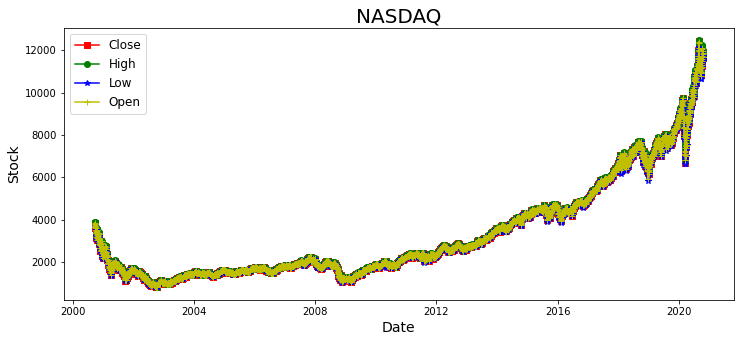

In [67]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('NASDAQ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

# Step 2. 기본 통계분석으로 이상치 찾기
- 데이터의 분포를 그려보기
- z-test로 정규분포를 만족하는지 확인하기
- (정규분포를 만족하지 않으면) Time series decompose 수행후 residual로 분석하기

## 한 단계 더 나아가기
- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이상치들을 제거/교정해야할지 내버려둘지 고민하기

## z-test : 우리 데이터는 정규분포인지 확인해 보기

- 우리가 가진 나스닥 데이터의 분포를 그래프로 확인해볼께요.
- 정규분포는 다음과 같이 그릴수 있어요.

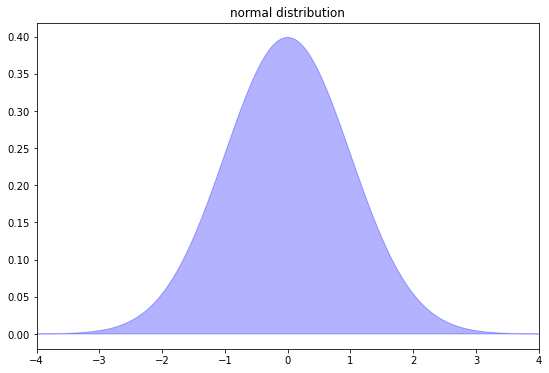

In [70]:
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(-5, 5, 0.001)
y = norm.pdf(x,0,1) 
# 평균이 0이고, 표준편차가 1인 정규분포를 그립니다.

# build the plot
fig, ax = plt.subplots(figsize=(9,6))
ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.set_xlim([-4,4])
ax.set_title('normal distribution')
plt.show()

나스닥 데이터 분포를 확인하기 위해 주식의 '종가 Close'를 그려보자

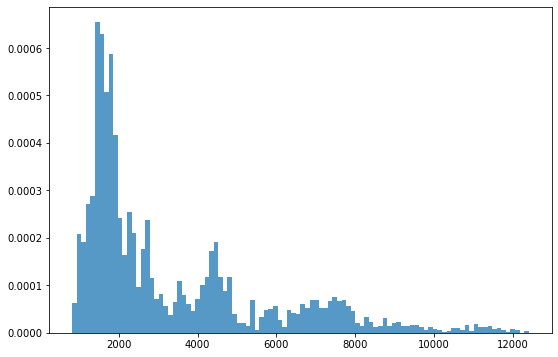

In [72]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

정규분포와는 거리가 멀어보이는데, 단변수의 정규분포 여부는 z-test 방법으로 확인해 봅시다. 

In [73]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


- p가 0.05 이하로 나왔으므로 normal distribution과 거리가 멉니다. 
- 즉, 이런 데이터로는 '정규분포'를 가정한 통계적 추정이 어려우므로, 정규분포를 가정한 신뢰구간 분석은 적용하기 어렵습니다. 

## 시계열 데이터 중에서 정규분포에 가까운 데이터를 뽑아내는 방법 : Time series decomposition

(1) statsmodel 에서 제공하는 Time series decomposition 은 시계열 데이터를 3가지 패턴으로 분류됩니다. 

- trend
- seasonal
- residual (또는 resid): stationary에 가까운 데이터는 정규분포를 따름

(2) Time series decomposition은 'additive' 방법과 'multiplicative' 방법이 있어요. 본 예제에서는 additive 방법을 적용해봅니다. 

- 계절적 성분의 주기는 임의로 50일로 가정하겠습니다.

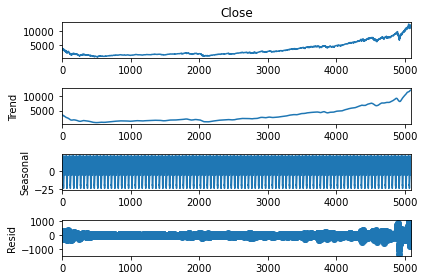

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

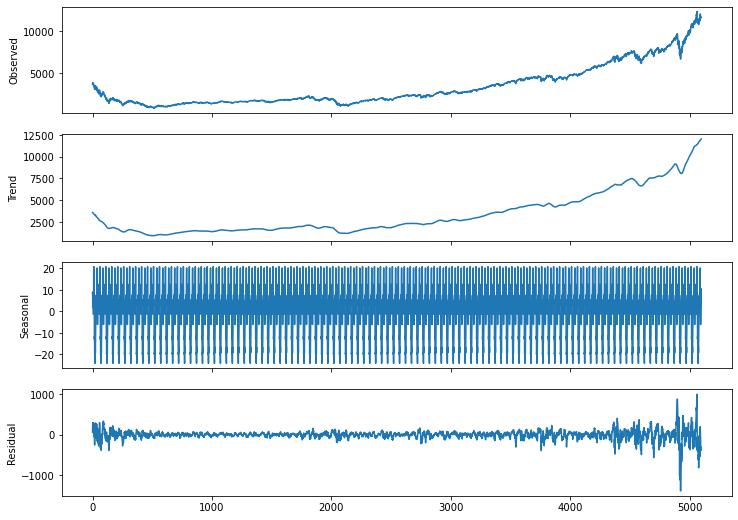

In [75]:
#그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

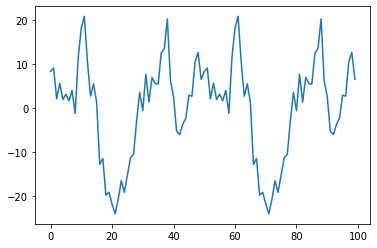

In [77]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:100].plot()
#-25 에서 20 사이를 주기적으로 반복하는게 보이네요.

# Time series decompose 결과에서 확인할 수 있는 것
- 우리는 정규분포에서 표준편차를 이용한 이상치 인식을 사용하고 싶었어요
- 추세 Trend 와 계절적 성분Seasonal을 뽑아내고 남은 잔차Residual를 볼까요?
- 잔차는 평균 0을 기준으로 분포하고 있어요!
- 잔차가 큰 날은 뭔가 일반적인 추세나 계절성에서 벗어난 날로 해석되겠죠?
- 그럼 Residual의 분포를 그려보도록 하겠습니다

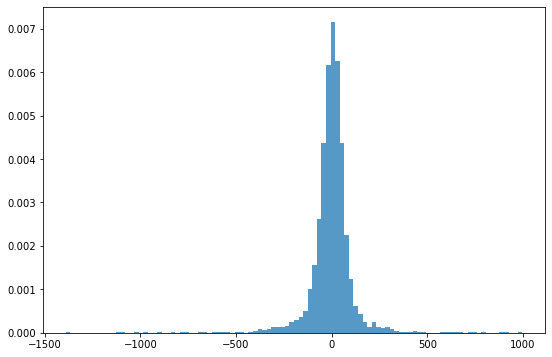

In [78]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

정규분포로 가정해도 될지 여부를 z-test를 통해 숫자로 확인해 봅시다. 

In [79]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.8390076883668396 0.40146499522520807


- p-value가 0.05 이상으로 아주 강하게 나타나네요. 
- 데이터 분포가 정규분포를 잘 따르고 있다는 뜻입니다.
- 이러면 정규분포로 가정하고 분석해도 되겠습니다.


## 3σ 기준 신뢰구간으로 이상치 찾기

- 여러분은 신뢰구간 방법으로 이상치를 탐색해봅시다. 
- 평균을 기준으로 플러스/마이너스 3σ를 벗어나는 데이터를 찾아봅시다.

In [80]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.2913972051412874 표준편차: 109.89901935436704
이상치 갯수: 92


5098개의 데이터 샘플 중에서 92개의 이상치를 찾아냈습니다.

어떤 날들인지 확인해볼까요?

In [81]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
          ...    
5083   2020-10-05
5084   2020-10-06
5085   2020-10-07
5096   2020-10-22
5097   2020-10-23
Name: Date, Length: 92, dtype: datetime64[ns]

# Step 3. Unsupervised Clustering 으로 이상치 찾기
- k-means로 분석하기
- DBSCAN으로 분석하기

## 한 단계 더 나아가기
- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이 이상치를 제거/교정해야할지 내버려둘지 고민하기

In [82]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,3330.724999,3362.220146,3298.532406,3332.609090,288057.188854
std,2400.892883,2422.863050,2379.665832,2404.825139,109834.091507
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.407500,1597.671250,1571.153750,1584.352001,220586.700000
50%,2264.797500,2292.105000,2232.207500,2265.174199,268932.110000
75%,4434.168125,4466.316875,4401.132500,4435.347500,319674.830000
max,12039.860297,12201.437499,11870.369861,12047.090432,776809.340000


In [83]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000
mean,-1.361168,-1.421971,-1.241082,-1.314223,155.136515
std,112.249407,102.051145,116.463672,110.054996,110706.241180
min,-1280.580676,-1494.706438,-1226.976539,-1390.196689,-602731.340129
25%,-38.117788,-35.393102,-38.318769,-37.788724,-53311.671523
50%,3.476876,3.331959,4.089242,2.923191,-488.997470
75%,40.164011,37.638459,41.675332,40.863314,51480.694345
max,996.954616,933.609579,944.823580,996.320780,810713.135421


- 각 변수마다의 잔차(residual)을 살펴보면 Volume 숫자가 혼자서 너무 크다는 것을 발견할 수 있습니다. 
- 이런 데이터를 그대로 분석에 사용하면 Volume이 가장 중요하게 반영되므로, 
- 한쪽에 쏠리는걸 제외하기 위해 각 변수들을 표준정규화 해줍니다.

In [84]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.36116811  -1.42197139  -1.24108161  -1.31422283 155.13651478]


array([[ 0.94892246,  0.84646493,  0.81728626,  0.60184276,  0.08322602],
       [ 0.49026957,  1.28420778,  1.38842808,  2.09551792,  0.10454779],
       [ 1.90750707,  2.01838985,  2.0481367 ,  2.7378712 , -0.08888583],
       ...,
       [-2.9355638 , -3.75950684, -2.18973446, -2.93558305,  0.44805172],
       [-3.02900188, -4.45234664, -3.01260131, -3.46542972,  0.39484453],
       [-3.32615554, -5.03188414, -2.82731937, -3.56760069,  0.48127544]])

### K-means 와 DBSCAN

- k-means 와 DBSCAN 은 대표적인 unsupervised clustering 알고리즘입니다. 
- 입력된 데이터들을 유사한 몇개의 그룹으로 분류해줍니다.
- k-means 은 몇개의 그룹으로 묶는지 지정할 수 있는 반면, DBSCAN은 지정할 수 없어요.

## k-means 로 이상치 탐색하기
- 우리는 k-means을 이용해서 정상 데이터그룹과 이상치 데이터그룹을 나눠볼꺼에요.
- 이때, 그룹은 2개로 지정하면 되겠죠? 한번 코드로 확인해보겠습니다.

In [85]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[1 1 1 ... 0 0 0]


In [86]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[1099 3999]


분석 결과 0번그룹은 1099개의 샘플, 1번그룹은 3999개의 샘플로 분류됐어요. 

어느 한쪽을 이상치 그룹이라고 선택하기에는 너무 많이 분류됐네요.

그룹 숫자를 더 늘려서 분석해보겠습니다.

In [87]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:1008',
 'group:1-count:66',
 'group:2-count:1097',
 'group:3-count:18',
 'group:4-count:296',
 'group:5-count:495',
 'group:6-count:459',
 'group:7-count:33',
 'group:8-count:19',
 'group:9-count:831',
 'group:10-count:331',
 'group:11-count:98',
 'group:12-count:11',
 'group:13-count:98',
 'group:14-count:238']

특이그룹 번호는 여러분들의 수행 결과에 따라 다를 수 있습니다. 그러나 이렇게 특이하게 분류된 그룹에 속한 데이터의 경우 유사한 날들이 거의 없다는 뜻이므로 우리가 찾고 있는 이상치로 볼수 있습니다.

다음 활동을 통해 이상치를 분석해 보겠습니다.

1. 어떤 날들이 분류된건지
2. 각 그룹은 어떤 특징을 갖고 있는지
3. 왜 이상치로 분류된걸까?

✔️1. 어떤 날들이 분류된건지 (원본 코스피 데이터에서 탐색)

In [88]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==3)|(kmeans.labels_==8)|(kmeans.labels_==12)]

,Date,Open,High,Low,Close,Adj Close,Volume
4362,2018-01-24,6956.500000,7004.250000,6888.250000,6931.250000,6931.250000,526387.0
4399,2018-03-19,7043.000000,7043.000000,6821.250000,6914.250000,6914.250000,571979.0
4537,2018-10-04,7651.000000,7651.000000,7456.500000,7514.250000,7514.250000,704908.0
4578,2018-12-04,7055.250000,7055.250000,6783.000000,6803.250000,6803.250000,811925.0
4680,2019-05-06,7810.000000,7817.500000,7667.500000,7803.500000,7803.500000,630196.0
4681,2019-05-07,7744.750000,7804.000000,7581.250000,7674.000000,7674.000000,838952.0
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4892,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4893,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4894,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0


In [89]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5098.000000,5098.000000,5098.000000,5098.000000,5098.000000,5.098000e+03
mean,3329.358747,3360.794284,3297.286767,3331.291122,3331.291122,2.882167e+05
std,2400.978546,2422.128357,2380.456260,2404.769584,2404.769584,1.595897e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1593.500000,1608.500000,1576.500000,1593.125000,1593.125000,1.907512e+05
50%,2232.000000,2259.875000,2211.750000,2232.875000,2232.875000,2.657315e+05
75%,4447.000000,4469.875000,4419.437500,4451.187500,4451.187500,3.562115e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [92]:
# 4922 주변 정황
df.iloc[4900:4940]

,Date,Open,High,Low,Close,Adj Close,Volume
4900,2020-02-23,9355.25,9365.00,9289.00,9315.00000,9315.00000,995989.0
4901,2020-02-24,9355.25,9365.00,9041.25,9091.00000,9091.00000,1171879.0
4902,2020-02-25,9091.00,9224.25,8810.00,8854.25000,8854.25000,1344897.0
4903,2020-02-26,8868.25,9037.50,8709.50,8850.25000,8850.25000,1251412.0
4904,2020-02-27,8811.50,8878.50,8334.25,8382.75000,8382.75000,1580041.0
4905,2020-02-28,8347.00,8574.75,8126.25,8454.00000,8454.00000,1527204.0
4906,2020-03-01,8347.00,8574.75,8126.25,8382.75000,8382.75000,1513887.0
4907,2020-03-02,8349.25,8883.25,8224.25,8791.25000,8791.25000,1373357.0
4908,2020-03-03,8830.50,9002.50,8511.00,8582.50000,8582.50000,1295648.0
4909,2020-03-04,8557.50,8950.00,8508.25,8896.50000,8896.50000,939032.0


✔️2. 각 그룹은 어떤 특징을 갖고 있는지

In [93]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,0.194578,0.193084,0.252013,0.233630,-0.443905
1,-1.333821,-1.483672,-2.026410,-2.027606,3.052986
2,-0.234961,-0.237032,-0.220148,-0.218888,0.175160
3,2.867673,2.755949,2.001638,1.941786,2.835088
4,-0.019224,-0.041160,-0.306351,-0.279899,1.701011
5,0.868996,0.903342,0.935606,0.923896,-0.310361
6,-0.899405,-0.912158,-0.888788,-0.866056,0.467757
7,-4.195611,-4.554132,-4.181233,-4.167360,0.790436
8,6.092861,6.187818,6.208749,6.171515,-0.432828
9,0.316971,0.346216,0.271677,0.288842,0.449370


- 다른 그룹들은 거래량 값이 매우 작지만, 2개 그룹의 거래량 수치가 유독 큽니다. 1,3번 그룹이 이 경우입니다.
- 그리고 Open, High, Low, Close의 값이 유독 낮은 그룹이 하나 있습니다. 12번 그룹이 이 경우입니다.

✔️3. 왜 이상치로 분류된걸까?
- 1번 3번 그룹의 거래량은 비정상적입니다.

- 12번 그룹은 각 그룹의 특징에서 답을 찾을수 있었어요.
슬프게도 나스닥 역사상 가장 큰 폭락장이었던 날입니다.

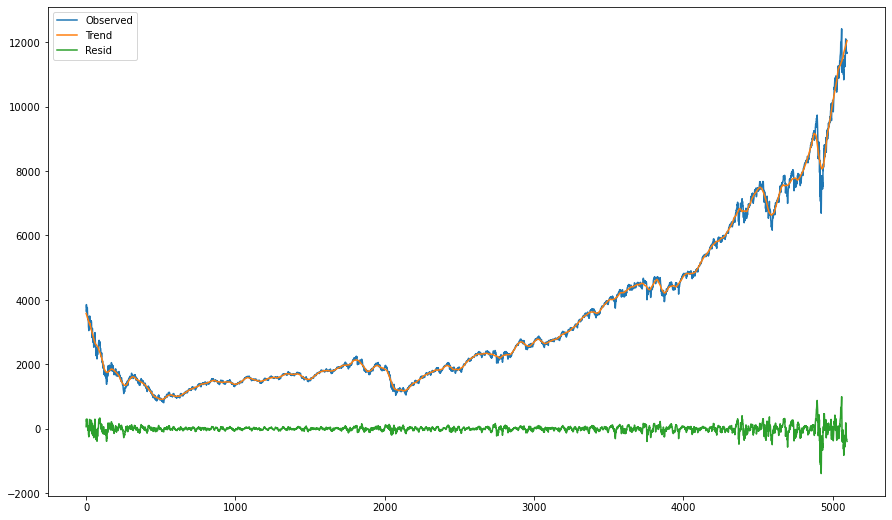

In [95]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

파란색은 실제 나스닥지수고, 빨간색은 트렌드, 그리고 잔차가 노란색입니다.

COVID19 때문에 올해 3월에 발생한 폭락장으로 인해 아래로 깊게 파인 잔차가 보입니다.

기대했던 추세보다 너무 많이 하락한거죠

즉, 우리가 예상하지 못한 이상치가 맞습니다.

## Recap

우리는 Unsupervised Learning 중에서 K-means 알고리즘을 이용해서 Anomaly Detection을 해봤어요

- 소수그룹이 형성될 만큼 충분한 그룹수로 클러스터링 한다
- 소수그룹의 특징을 분석한다
- 해당 소수그룹들이 이상치인지 추론해본다.

## DBSCAN 으로 이상치 찾기
이번에 우리는 DBSCAN 을 이용해서 데이터를 클러스터링하고, 이상치 그룹을 찾아낼꺼에요.
- K-means과 달리, DBSCAN 알고리즘은 클러스터의 개수를 지정할 필요가 없습니다. 아주 간단히 말해서, DBSCAN 알고리즘은 핵심벡터와 일정 거리 ϵ 이내인 데이터 벡터들이 군집(Cluster)을 이루게 하는데, 그러한 군집들과 거리상 동떨어져 군집에 들지 못하는 특이한 데이터들을 노이즈(Noise) 벡터라고 부릅니다.
- DBSCAN을 통해 이상치를 찾는 것은 바로 이러한 노이즈 벡터를 찾는 것과 같습니다.


In [96]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [97]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[ 0  0  0 ... 24 25 25]


In [98]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:197',
 'group:0-count:4839',
 'group:1-count:2',
 'group:2-count:2',
 'group:3-count:12',
 'group:4-count:2',
 'group:5-count:2',
 'group:6-count:2',
 'group:7-count:2',
 'group:8-count:3',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:2',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:2',
 'group:21-count:3',
 'group:22-count:2',
 'group:23-count:2',
 'group:24-count:2',
 'group:25-count:2']

DBSCAN은 197개, 13개, 3개, 2개의 소수그룹을 분류해냈네요.

# Step 4. LSTM 오토인코더로 이상치 찾기

- 딥러닝을 위한 데이터셋 만들기
- 오토인코더 모델 생성하기
- 학습이 정상적으로 수행됐는지 확인하기

## 한 단계 더 나아가기

- 앞선 두가지 방법과 비교하기
- 다른 이유가 뭔지 확인해보기
- 더 나은 형태의 오토인코더 모델을 만들어보기

In [99]:
# 필요한 라이브러리를 불러옵니다

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [135]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

# LSTM 을 이용한 오토인코더 모델 만들기
## 데이터 전처리

- 입력 변수를 정규화시켜줘야 딥러닝 모델 학습이 원활합니다
- 가장 일반적인 표준정규분포로 전처리해요


In [136]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 5
batch_size = 16
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

## keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

- data : 입력데이터(x)를 넣어줍니다. 우리는 'Open','High','Low','Close','Volume' 5가지 인풋을 사용합니다.
- targets : 출력데이터를 넣어줍니다. 우리는 5가지 인풋 그대로 예측하기 때문에 data와 동일한걸 넣어줍니다.
- length : 몇개의 time_step을 참고할지 입력합니다.
- stride : time_step 사이즈를 결정합니다.


In [137]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(16, 5, 5)
(16, 5)


## 모델 만들기
- 2개 층의 LSTM으로 인코더를 만듭니다
- RepeatVector는 input을 window_size 만큼 복사해줍니다.


In [138]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 5, 64)             17920     
_________________________________________________________________
lstm_17 (LSTM)               (None, 16)                5184      
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 5, 16)             2112      
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                20736     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
__________________________________________________

In [139]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=12)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [140]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=100, 
          callbacks=[checkpoint, early_stop])

Epoch 1/100
319/319 [==============================] - ETA: 0s - loss: 0.8418 - mae: 0.8418
Epoch 00001: val_loss improved from inf to 0.60534, saving model to /home/aiffel0042/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
319/319 [==============================] - 5s 16ms/step - loss: 0.8418 - mae: 0.8418 - val_loss: 0.6053 - val_mae: 0.6053
Epoch 2/100
318/319 [============================>.] - ETA: 0s - loss: 0.3794 - mae: 0.3794
Epoch 00002: val_loss improved from 0.60534 to 0.39640, saving model to /home/aiffel0042/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
319/319 [==============================] - 5s 16ms/step - loss: 0.3787 - mae: 0.3787 - val_loss: 0.3964 - val_mae: 0.3964
Epoch 3/100
316/319 [============================>.] - ETA: 0s - loss: 0.3646 - mae: 0.3646
Epoch 00003: val_loss did not improve from 0.39640
319/319 [==============================] - 5s 15ms/step - loss: 0.3628 - mae: 0.3628 - val_loss: 0.4520 - val_mae: 0.4520
Epoch 4/100
319/319 [======================

In [141]:
model.load_weights(checkpoint_path)

학습 과정을 확인해보겠습니다.
- 안정적으로 Training loss 가 수렴하고
- Validation loss 가 발산하지 않음을 확인
잘 학습되는거 같네요!

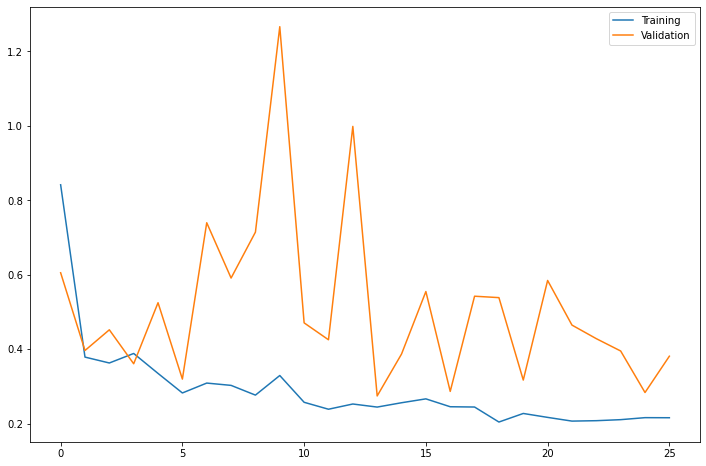

In [142]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

### 분석 시 주의할 점!!
우리는 시계열 데이터를 window_size 만큼 밀어가면서 예측하는 모델을 만들었어요.

그래서 train_gen의 길이는 원본 df의 길이보다 window_size 만큼 짧습니다.

예측결과와 비교할때는 scaled의 앞에서 window_size 만큼을 건너 뛰어해야해요.

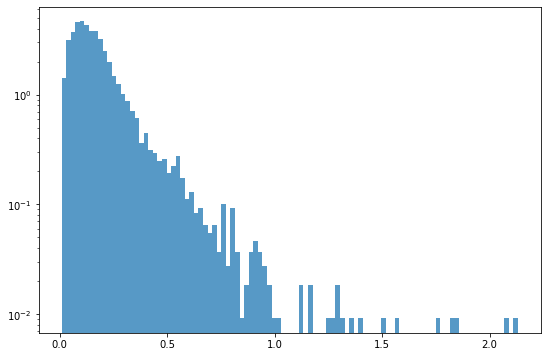

In [143]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

mae_loss가 1.0 이상으로 동떨어진 샘플이 몇개 보입니다. 
아무래도 우리가 찾는 이상치 같습니다 좀더 자세히 확인해보겠습니다.

mae_loss의 기준치를 3으로 해서 분석합니다.

scaled 데이터는 스케일링 조정되어있기 때문에 원본 데이터인 df로 비교해야합니다.

기존의 df와 mae_loss 까지 합쳐서 분석하기 위한 데이터프레임을 새로 하나 만들어요

In [144]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 1.0
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
4365,2018-02-05,6752.25,6813.50,6387.75,6429.250000,6429.250000,931677.0,1.157950
4537,2018-10-11,7010.25,7138.00,6907.75,7031.000000,7031.000000,1146270.0,1.314175
4585,2018-12-21,6307.50,6317.75,6242.00,6257.250000,6257.250000,862689.0,1.159544
4896,2020-02-24,9355.25,9365.00,9041.25,9091.000000,9091.000000,1171879.0,1.129815
4897,2020-02-25,9091.00,9224.25,8810.00,8854.250000,8854.250000,1344897.0,1.352761
4898,2020-02-26,8868.25,9037.50,8709.50,8850.250000,8850.250000,1251412.0,1.129722
4899,2020-02-27,8811.50,8878.50,8334.25,8382.750000,8382.750000,1580041.0,1.831672
4900,2020-02-28,8347.00,8574.75,8126.25,8454.000000,8454.000000,1527204.0,1.759553
4901,2020-03-01,8347.00,8574.75,8126.25,8382.750000,8382.750000,1513887.0,1.839686
4902,2020-03-02,8349.25,8883.25,8224.25,8791.250000,8791.250000,1373357.0,2.087650


우리가 Clustering 에서 찾았던 Volume 이상치 4개를 똑같이 찾았네요!

이상치 탐지가 정상적으로 동작하는거 같아요!!

기준치를 더 낮춰서 보다 많은 이상치를 찾아보겠습니다



In [147]:
threshold = 0.5
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
630,2003-03-21,1090.000000,1095.500000,1070.000000,1094.579956,1094.579956,266617.0,0.516133
886,2004-03-19,1422.000000,1428.500000,1409.500000,1415.750000,1415.750000,299916.0,0.543482
1089,2005-01-03,1628.000000,1644.000000,1605.000000,1615.500000,1615.500000,365482.0,0.558330
1141,2005-03-18,1488.500000,1493.000000,1483.000000,1486.900024,1486.900024,318215.0,0.561390
1397,2006-03-21,1706.500000,1727.500000,1687.500000,1690.500000,1690.500000,439769.0,0.512727
...,...,...,...,...,...,...,...,...
5078,2020-10-05,11308.500000,11497.500000,11267.500000,11469.200195,11469.200195,398444.0,0.557388
5081,2020-10-08,11473.200195,11578.799805,11469.799805,11539.000000,11539.000000,403379.0,0.534062
5082,2020-10-09,11562.000000,11739.000000,11552.500000,11724.799805,11724.799805,408445.0,0.543019
5083,2020-10-12,11722.799805,12197.000000,11687.799805,12098.200195,12098.200195,756438.0,0.757329


## 그래프로 그려서 이상치를 찾아봐요
- Open, Close, Low , High 같은 데이터는 스케일이 비슷하니 한번에 그려도 좋을거에요
- 하지만 Volume과 loss는 스케일이 다르니 각각 그래프를 그려봐요
- 기준치로 분류해낸 이상치들은 붉은 점으로 그려서 나타내요

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


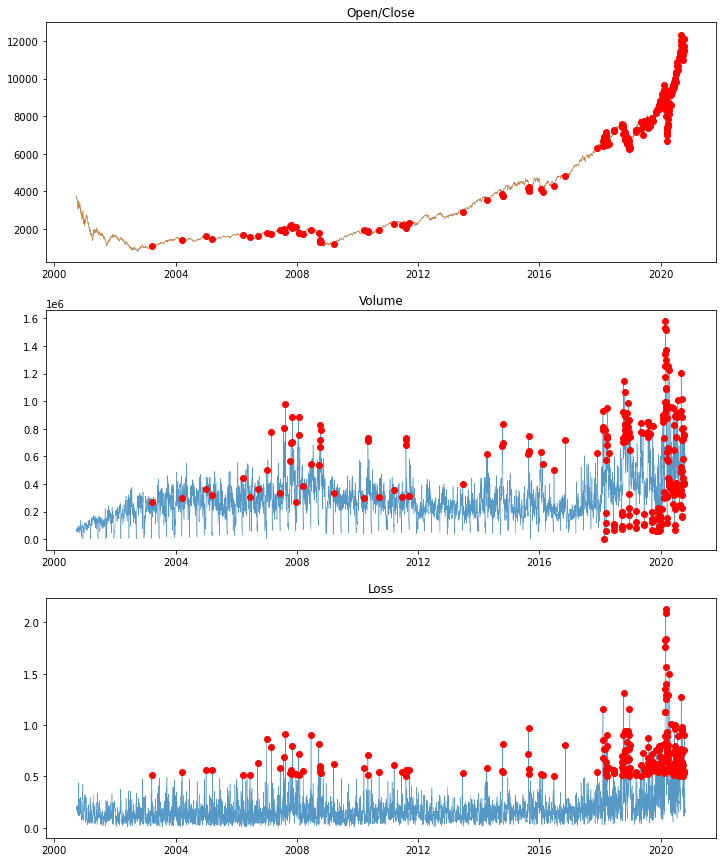

In [148]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

그래프에 붉게 표시된 이상치들이 한눈에 보이시나요?

이렇게 나스닥 데이터에 있는 이상치들을 찾아봤습니다.